<a href="https://colab.research.google.com/github/JessicaLLenz/DSCIrepo/blob/main/Copy_of_DSCI425_lab2_1_predicting_earns_by_college_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import seaborn as sns
import altair as alt
import plotnine as p9

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Lab 2.1 - Predicting Median Earnings by College Features

In this lab, we will build a model that predicts the median earnings of college graduates based on statistics on their respective college.

**Objectives.**
1. Visualize relationships with JMP Graph Builder,
2. Build a `sklearn` preprocessing pipeline based on **1.**, and
3. Use a grid search to identify the best parameters.

#

## Step 1 - Visualize the relationships in JMP Graph Builder

**Note.** I find time spent writing visualization code to be a waste of time and prefer to do my initial visualizations in a full feature drag-and-drop tool like JMP's Graph Builder.

### Task 1.

Follow along with the instructor and paste the screenshot of the visualization below.

*PASTE SCREENSHOT HERE*
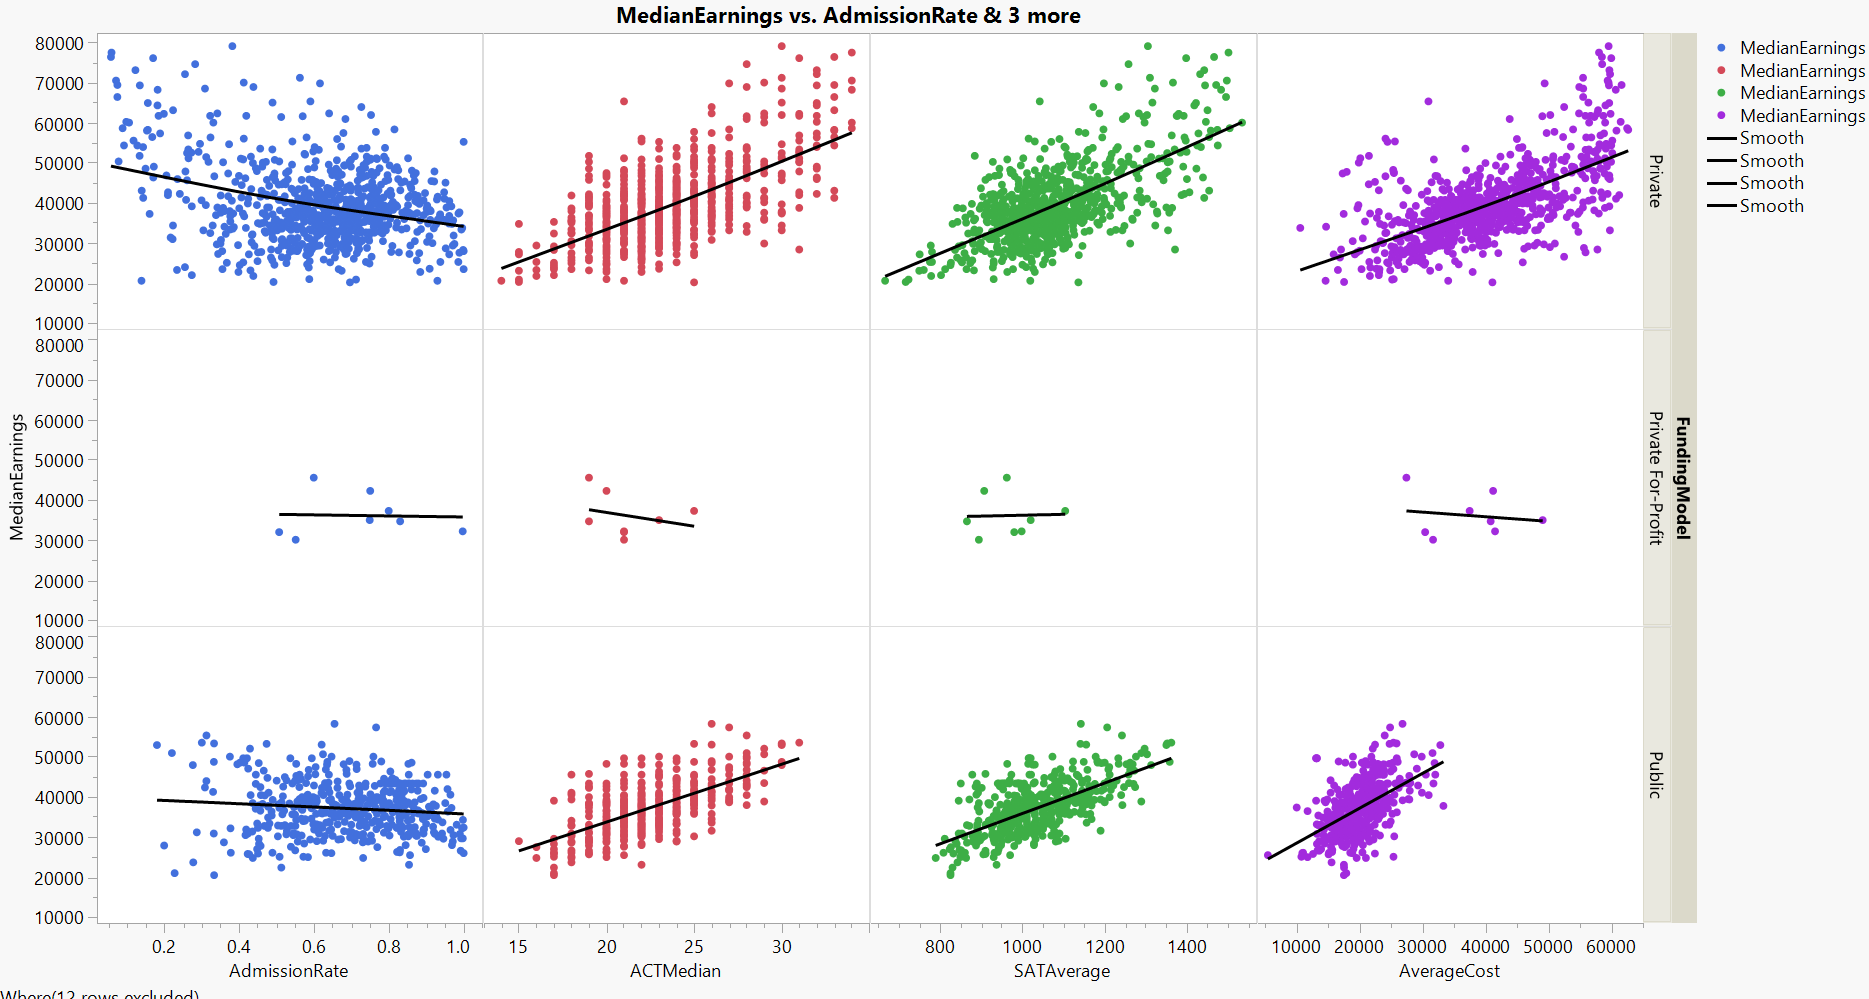

### Results

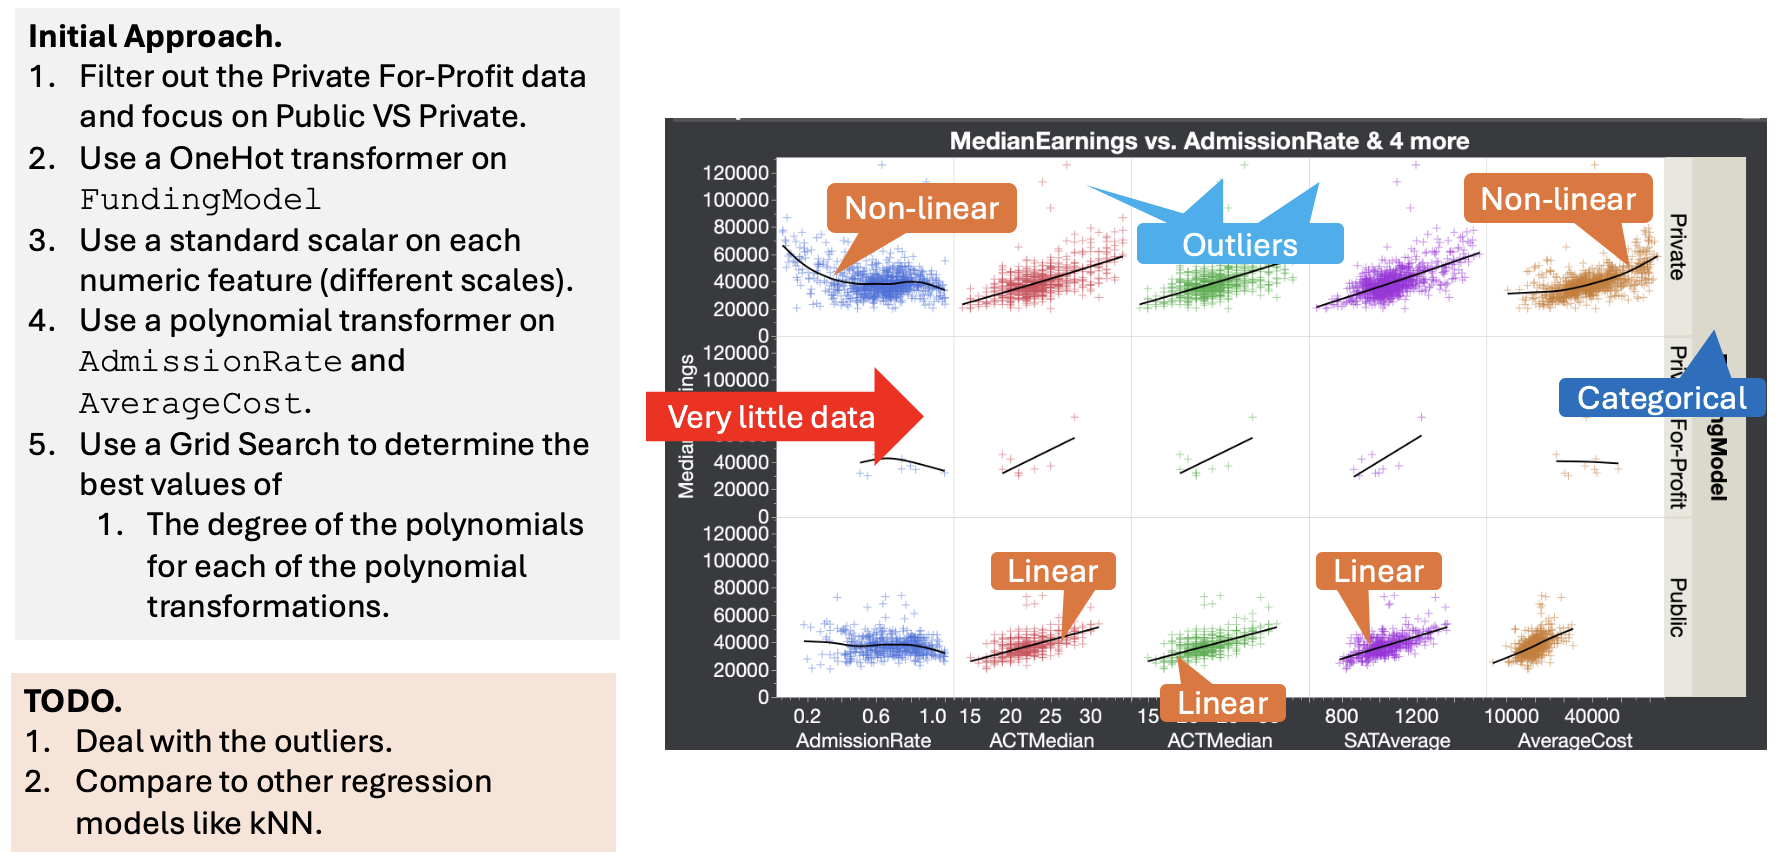

## Step 2 - Load the data.

In [3]:
# Your code here
(earnings :=
 pl.read_csv("/content/college_earnings.csv")
 )

FundingModel,AdmissionRate,ACTMedian,SATAverage,AverageCost,MedianEarnings
str,f64,i64,i64,i64,i64
"""Public""",0.8989,17,823,18888,27000
"""Public""",0.8673,25,1146,19990,37200
"""Public""",0.8062,26,1180,20306,41500
"""Public""",0.5125,17,830,17400,22400
"""Public""",0.5655,26,1171,26717,39200
…,…,…,…,…,…
"""Public""",0.594,24,1020,12946,49700
"""Public""",0.4107,21,1017,13028,49700
"""Public""",0.6443,20,954,22570,35800


## Step 3 - Make lists of features by type.

Next we want to make lists of the
1. Numeric features,
2. Categorical features,
3. Linear features

In [22]:
from numpy import column_stack
# Your code here (make new cells as needed.)
(num_feat :=
 earnings.select(cs.numeric() - cs.by_name('MedianEarnings'))
 .columns
)


['AdmissionRate', 'ACTMedian', 'SATAverage', 'AverageCost']

In [23]:
(poly_feat :=
 ['AdmissionRate', 'AverageCost'])

['AdmissionRate', 'AverageCost']

In [24]:
(lin_feat :=
 ['ACTMedian', 'SATAverage']
 )

['ACTMedian', 'SATAverage']

In [25]:
(cat_feat :=
 earnings.select(cs.string()).columns)

['FundingModel']

## Step 4 - Create the `X` and `y` data structures.

In [26]:
# Define X_earnings
(X_earning :=
 earnings.filter(pl.col('FundingModel') != 'Private For-Profit')
 .drop('MedianEarnings').to_pandas()
 )

,FundingModel,AdmissionRate,ACTMedian,SATAverage,AverageCost
0,Public,0.8989,17,823,18888
1,Public,0.8673,25,1146,19990
2,Public,0.8062,26,1180,20306
3,Public,0.5125,17,830,17400
4,Public,0.5655,26,1171,26717
...,...,...,...,...,...
1280,Public,0.6579,22,1024,18097
1281,Public,0.4207,22,1015,13099
1282,Public,0.5940,24,1020,12946
1283,Public,0.4107,21,1017,13028


In [27]:
# Define y_earnings
(y_earnings :=
 earnings.filter(pl.col('FundingModel') != 'Private For-Profit')
 .get_column('MedianEarnings')
 .to_numpy()
)

array([27000, 37200, 41500, ..., 49700, 49700, 35800])

## Step 5a - Create pipelines for each type of feature.

1. Categorical features $\longrightarrow$ `OneHotEncoder`.
2. Linear features $\longrightarrow$ `StandardScaler`.
3. Polynomial feature $\longrightarrow$ `StandardScaler` $\longrightarrow$ `PolynomialFeatures`.

In [28]:
# Degine the categorial transformer
(linear_transformer := Pipeline(
    steps=[
           ('scaler', StandardScaler())
    ]
))

Pipeline(steps=[('scaler', StandardScaler())])

In [29]:
# Define the linear transformer
(categorical_transformer := Pipeline(
    steps=[
           ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [30]:
# Define the polynomial transformer
(poly_transformer := Pipeline(
    steps=[
           ('scaler', StandardScaler()),
           ('poly', PolynomialFeatures())
    ]
 ))

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures())])

## Step 5b - Combine the various transformers

In [31]:
# Build the combined preprocessor here
(preprocessor := ColumnTransformer(
    transformers = [
        ("linear", linear_transformer, lin_feat),
        ("cat", categorical_transformer, cat_feat),
        ("admin", poly_transformer, ['AdmissionRate']),
        ("cost", poly_transformer, ['AverageCost'])
    ]
))

ColumnTransformer(transformers=[('linear',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['ACTMedian', 'SATAverage']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['FundingModel']),
                                ('admin',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures())]),
                                 ['AdmissionRate']),
                                ('cost',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures())]),
                                 ['AverageCost'])])

In [32]:
preprocessor.fit(X_earning, y_earnings)

ColumnTransformer(transformers=[('linear',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['ACTMedian', 'SATAverage']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['FundingModel']),
                                ('admin',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures())]),
                                 ['AdmissionRate']),
                                ('cost',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures())]),
                                 ['AverageCost'])])

## Step 5c - Combine the preprocessor and regression model.

**Note.** It is good practice to test `model.fit(...)` here to identify any bugs.

In [33]:
# Combined the preprocessor and regression model
(model := Pipeline(
    steps=[
           ('preprocessor', preprocessor),
           ('regressor', LinearRegression())
    ]
))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('linear',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ACTMedian', 'SATAverage']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['FundingModel']),
                                                 ('admin',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['AdmissionRate']),
                                                 ('cost',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['AverageCost'])])),
                ('regressor', LinearRegression())])

In [34]:
# Test model.fit(...)
model.fit(X_earning, y_earnings)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('linear',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['ACTMedian', 'SATAverage']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['FundingModel']),
                                                 ('admin',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['AdmissionRate']),
                                                 ('cost',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['AverageCost'])])),
                ('regressor', LinearRegression())])

## Step 6 - Build a grid of parameters and grid search

In [35]:
# Use model.get_params() to identify parameters
model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('linear',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['ACTMedian', 'SATAverage']),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['FundingModel']),
                                   ('admin',
                                    Pipeline(steps=[('scaler', StandardScaler()),
                                                    ('poly',
                                                     PolynomialFeatures())]),
                                    ['AdmissionRate']),
                                   ('cost',
                                    Pipeline(steps=[('scaler', StandardScaler()),
                                                    ('

In [36]:
# Create a grid search
(grid :=
 {'preprocessor__admin__poly__degree': [2, 3, 4],
  'preprocessor__admin__poly__include_bias': [True, False],
  'preprocessor__cost__poly__degree': [2, 3, 4],
  'preprocessor__cost__poly__include_bias': [True, False],
  }
 )

{'preprocessor__admin__poly__degree': [2, 3, 4],
 'preprocessor__admin__poly__include_bias': [True, False],
 'preprocessor__cost__poly__degree': [2, 3, 4],
 'preprocessor__cost__poly__include_bias': [True, False]}

In [37]:
# Preform the grid search
grid_search = GridSearchCV(model, grid, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

grid_search.fit(X_earning, y_earnings)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('linear',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ACTMedian',
                                                                          'SATAverage']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['FundingModel']),
                                                                        ('admin',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()...
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures())]),
                                                                         ['AverageCost'])])),
                                       ('regressor', LinearRegression())]),
             n_jobs=1,
             param_grid={'preprocessor__admin__poly__degree': [2, 3, 4],
                         'preprocessor__admin__poly__include_bias': [True,
                                                                     False],
                         'preprocessor__cost__poly__degree': [2, 3, 4],
                         'preprocessor__cost__poly__include_bias': [True,
                                                                    False]},
             scoring='neg_mean_squared_error', verbose=1)

In [39]:
# Identify the best parameters
grid_search.best_params_

{'preprocessor__admin__poly__degree': 3,
 'preprocessor__admin__poly__include_bias': True,
 'preprocessor__cost__poly__degree': 2,
 'preprocessor__cost__poly__include_bias': True}

In [40]:
grid_search.best_score_

np.float64(-54581777.624902986)

In [41]:
grid_search.best_index_

np.int64(12)

In [42]:
(-1*grid_search.best_score_)**0.5

np.float64(7387.948133609425)